## Regularization 

Michel Kana, DigIntu Tech Ltd, Prague, Czech Republic 


<hr style="height:2pt">

In [28]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools

import seaborn as sns

%matplotlib inline

# Continuing Bike Sharing Usage Data

In this project, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See project 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



**Part 1: Data pre-processing**

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as we read it in.

#### Read the dataset 

*Import the CSV data file into a dataframe*

In [6]:
bikes_main = pd.read_csv('data/bikes_student.csv', index_col='Unnamed: 0')

*Explore the data*

In [3]:
bikes_main.columns.values

array(['dteday', 'hour', 'year', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri',
       'Sat', 'Cloudy', 'Snow', 'Storm', 'month'], dtype=object)

In [5]:
bikes_main.shape

(1250, 36)

In [6]:
bikes_main.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
5887,2011-09-07,19,0,0,1,0.64,0.5758,0.89,0.0000,14,...,0,0,1,0,0,0,1,0,0,9
10558,2012-03-21,1,1,0,1,0.52,0.5000,0.83,0.0896,4,...,0,0,1,0,0,0,0,0,0,3
14130,2012-08-16,23,1,0,1,0.70,0.6515,0.54,0.1045,58,...,0,0,0,1,0,0,0,0,0,8
2727,2011-04-28,13,0,0,1,0.62,0.5758,0.83,0.2985,18,...,0,0,0,1,0,0,1,0,0,4
8716,2012-01-04,0,1,0,1,0.08,0.0606,0.42,0.3284,0,...,0,0,1,0,0,0,0,0,0,1


In [7]:
bikes_main.describe()

,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.0,1250.000000
mean,11.410400,0.514400,0.030400,0.675200,0.494160,0.473600,0.63844,0.197306,36.050400,159.288000,...,0.140800,0.141600,0.15520,0.138400,0.129600,0.148000,0.276800,0.086400,0.0,6.533600
std,6.885456,0.499993,0.171754,0.468488,0.192529,0.171707,0.18818,0.123924,50.958026,161.031847,...,0.347954,0.348779,0.36224,0.345458,0.335997,0.355242,0.447596,0.281066,0.0,3.441503
min,0.000000,0.000000,0.000000,0.000000,0.040000,0.060600,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,5.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.50000,0.104500,3.000000,32.250000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000
50%,11.000000,1.000000,0.000000,1.000000,0.500000,0.484800,0.65000,0.194000,15.000000,113.500000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.000000
75%,17.000000,1.000000,0.000000,1.000000,0.660000,0.621200,0.80000,0.283600,50.000000,231.750000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,10.000000
max,23.000000,1.000000,1.000000,1.000000,0.940000,0.909100,1.00000,0.850700,362.000000,810.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,12.000000


#### Describe the dataset

We will work with a dataset contained in data/bikes_student.csv. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date in the years 2011 and 2012. There are 36 attributes in total: 


- `Unnamed: 0` (unique row identifier)
- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `year` (0 for 2011, 1 for 2012)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `workingday` (1 = the day is a working day, 0 = otherwise)
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)
- `count` (total number of rides that day made)
- `Feb` (1 = the day is a Feb day, 0 = otherwise)
- `Mar` (1 = the day is a Mar day, 0 = otherwise)
- `Apr` (1 = the day is a Apr day, 0 = otherwise)
- `May` (1 = the day is a May day, 0 = otherwise)
- `Jun` (1 = the day is a Jun day, 0 = otherwise)
- `Jul` (1 = the day is a Jul day, 0 = otherwise)
- `Aug` (1 = the day is a Aug day, 0 = otherwise)
- `Sep` (1 = the day is a Sep day, 0 = otherwise)
- `Oct` (1 = the day is a Oct day, 0 = otherwise)
- `Nov` (1 = the day is a Nov day, 0 = otherwise)
- `Dec` (1 = the day is a Dec day, 0 = otherwise)
- `spring` (1 = the day is a spring day, 0 = otherwise)
- `summer` (1 = the day is a summer day, 0 = otherwise)
- `fall` (1 = the day is a fall day, 0 = otherwise)
- `Mon` (1 = the day is Monday, 0 = otherwise)
- `Tue` (1 = the day is Tuesday, 0 = otherwise)
- `Wed` (1 = the day is Wednesday, 0 = otherwise)
- `Thu` (1 = the day is Thursday, 0 = otherwise)
- `Fri` (1 = the day is Friday, 0 = otherwise)
- `Sat` (1 = the day is Saturday, 0 = otherwise)
- `Cloudy` (1 = the weather is Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 0 = otherwise)
- `Snow` (1 = the weather is Light Snow, Light Rain + Thunderstorm, 0 = otherwise)
- `Storm` (1 = the weather is Heavy Rain + Thunderstorm + Mist, Snow + Fog, 0 = otherwise)
- `month` (1 = Jan, 2= Feb, 3 = Mar, 4 = Apr, 5 = May, 6 = Jun, 7 = Jul, 8 = Aug, 9 = Sep, 10 = Oct, 11 = Nov, 12 = Dec)

If all binary predictors that represent months have the value 0 for a given row, then that row represents an observation done in the month of January.
If all binary predictors that represent week days have the value 0 for a given row, then that row represents an observation made on Sunday.
If all binary predictors that represent season have the value 0 for a given row, then that row represents an observation made on winter.
If all binary predictors that represent weather have the value 0 for a given row, then that row represents an observation made during clear weather.



**Split the dataset**

Split the data (1250 rows) into a training (80%) and a validation set (20%).

In [7]:
try:
    bikes_train, bikes_val = train_test_split(bikes_main, test_size = 0.2, random_state = 90, stratify=bikes_main['month'])
except:
    # Drop missing lines
    print("Lines with missing values dropped")
    bikes_main = bikes_main.dropna(subset=['month'])
    bikes_train, bikes_val = train_test_split(bikes_main, test_size = 0.2, random_state = 90, stratify=bikes_main['month'])

Verify that each month is represented equally within each set: ca 83 rows per month in the training set and ca. 21 rows per month in the validation set.

In [9]:
bikes_train.shape

(1000, 36)

In [10]:
bikes_train.groupby(['month']).count().dteday

month
1     82
2     78
3     85
4     82
5     86
6     83
7     86
8     85
9     82
10    83
11    82
12    86
Name: dteday, dtype: int64

In [11]:
bikes_val.groupby(['month']).count().dteday

month
1     21
2     19
3     21
4     21
5     21
6     21
7     21
8     21
9     21
10    21
11    21
12    21
Name: dteday, dtype: int64

**1.2** As with project 3, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test the code by producing `practice_y_train` and `practice_X_train`


**Drop columns**

Function that takes a data frame and a list of columns as parameters, and return a new dataframe where the columns have been dropped.

In [9]:
def drop_columns(df, cols):
    for col in cols:
        if col in df:
            df = df.drop(columns = [col])
    return df

Test the function on the train data set and create response and predictor data frames

In [10]:
cols_to_drop = ['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']
practice_y_train = drop_columns(bikes_train, bikes_train.columns.difference(['counts']))
practice_X_train = drop_columns(bikes_train, cols_to_drop)

Explore the response and predictor data frames ad verify that the specified columns have been correctly dropped

In [14]:
practice_y_train.head()

,counts
15762,111
4213,170
14301,16
15900,24
14320,306


In [15]:
practice_X_train.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
15762,23,1,0,0.54,0.5152,0.73,0.1045,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4213,11,0,0,0.76,0.6667,0.35,0.2239,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14301,2,1,0,0.66,0.6212,0.69,0.0000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15900,5,1,0,0.30,0.3030,0.81,0.1343,0,0,0,...,1,0,0,1,0,0,0,1,0,0
14320,21,1,0,0.70,0.6515,0.61,0.1642,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [16]:
practice_X_train.columns.values

array(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'], dtype=object)

**1.3** Write a function to standardize a provided subset of columns in the training/validation/test sets. Remember that while we will be scaling all of the data, we must learn the scaling parameters (mean and SD) from only the training set.

Test the code by building a list of all non-binary columns in the `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that we have correctly scaled all columns, including the polynomial columns.


**Standardize function**

Function that takes a data frame and a set of columns as parameters, and scales data using the mean and standard deviation of training data (also a parameter of the function). There are other standardization methods, for example dividing the data by their standard deviation only (without removing the mean). This later method is decribed in the class book. In this homework, we substract the mean as it was done in the lab.

The function will be used to standardize predictors prior to regularization. 

In [26]:
def standardize_columns(df, cols, scaler):
    df_copy = df.copy()
    df_copy[cols] = scaler.transform(df_copy[cols])
    return df_copy

**Standardize continuous predictors**

After unecessary columns have been dropped, the remaining predictors can be split into two groups.

* binary predictors: 
'holiday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'

* continuous predictors: 
'hour', 'temp', 'atemp', 'hum', 'windspeed', 'year'

In [29]:
binary_columns = ['holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
continuous_columns = practice_X_train.columns.difference(binary_columns)
scaler = StandardScaler().fit(practice_X_train[continuous_columns])

practice_X_train_scaled = standardize_columns(practice_X_train.astype(float), continuous_columns, scaler)

Verify if the continuous predictors have mean 0 (almost) and standard deviation 1

In [13]:
practice_X_train_scaled[continuous_columns].describe()

,atemp,hour,hum,temp,windspeed,year
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.256772e-16,-1.994516e-16,5.995204e-17,3.019807e-17,1.301181e-16,2.686740e-17
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-2.402605e+00,-1.646163e+00,-3.397602e+00,-2.347976e+00,-1.554205e+00,-1.018165e+00
25%,-8.121270e-01,-9.189949e-01,-7.421467e-01,-7.922693e-01,-7.231056e-01,-1.018165e+00
50%,7.147176e-02,-4.639332e-02,5.448995e-02,3.744066e-02,-1.130295e-02,9.821591e-01
75%,8.670022e-01,8.262083e-01,8.511266e-01,8.671507e-01,4.634972e-01,9.821591e-01
max,2.546131e+00,1.698810e+00,1.913309e+00,2.319143e+00,5.211499e+00,9.821591e-01


Verify scaling on validation set

In [20]:
standardize_columns(bikes_val, continuous_columns, scaler).describe()

,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.00000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.0,250.0000
mean,0.066463,0.054009,0.044000,0.652000,0.035781,0.030762,-0.034521,0.074947,37.744000,161.832000,...,0.13200,0.116000,0.12800,0.180000,0.140000,0.140000,0.264000,0.104000,0.0,6.5360
std,1.005123,0.999567,0.205507,0.477292,0.991393,1.006891,0.996533,0.922962,52.363942,166.616349,...,0.33917,0.320867,0.33476,0.384958,0.347683,0.347683,0.441684,0.305873,0.0,3.4491
min,-1.646163,-1.018165,0.000000,0.000000,-2.140548,-2.402605,-3.397602,-1.554205,0.000000,1.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0000
25%,-0.773561,-1.018165,0.000000,0.000000,-0.792269,-0.812127,-0.795256,-0.723106,4.000000,39.250000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.0000
50%,0.099040,0.982159,0.000000,1.000000,0.141154,0.160123,-0.051728,-0.011303,19.000000,118.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.0000
75%,0.971642,0.982159,0.000000,1.000000,0.867151,0.867002,0.784740,0.701295,51.500000,221.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,9.7500
max,1.698810,0.982159,1.000000,1.000000,2.111716,2.192692,1.913309,3.075296,307.000000,803.000000,...,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,12.0000


**1.4** Write a code to augment the dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. We should include ONLY pure powers of these columns. So with degree=2 we should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with apropriate inputs and outputs, and test the code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**Higher-oder function**

Function that takes a dataframe, a list of columns and a polynomial degree, and creates higher order features for the given columns.

For example if the degree is 3 and the columns list is ['x'], then the function will return a new dataframe with new columns x^2 and x^3 additional to the existing x. 

In [36]:
def create_higher_order(df, cols, degree):
    df_copy = df.copy()
    for col in cols:
        for order in range(2, degree + 1):
            col_name = col + '^' + str(order)
            if not col_name in df:
                df_copy[col_name] = df[col] ** order
    return df_copy

**Create higher order features of continuous variables**

The measured data contains the temperature (temp), relative temperature (atemp), humidity (hum), windspeed and hour.

The data is now augmented with temp^2, temp^3, atemp^2, atemp^3, hum^2, hum^3, windspeed^2, windspeed^3, hour^2, hour^3.

In [37]:
practice_X_train_poly = create_higher_order(practice_X_train_scaled, ['temp', 'atemp', 'hum', 'windspeed', 'hour'], 3)


Verify the new polynomial features

In [38]:
new_cols = practice_X_train_poly.columns.difference(list(practice_X_train.columns))
new_cols

Index(['atemp^2', 'atemp^3', 'hour^2', 'hour^3', 'hum^2', 'hum^3', 'temp^2',
       'temp^3', 'windspeed^2', 'windspeed^3'],
      dtype='object')

In [39]:
practice_X_train_poly[new_cols].head()

,atemp^2,atemp^3,hour^2,hour^3,hum^2,hum^3,temp^2,temp^3,windspeed^2,windspeed^3
15762,0.061889,0.015396,2.885955,4.902689,0.229789,0.110152,0.059960,0.014682,0.522882,-0.378099
4213,1.282270,1.452008,0.002152,-0.000100,2.367854,-3.643615,1.920218,2.660884,0.051300,0.011619
14301,0.751693,0.651719,1.836827,-2.489443,0.071250,0.019018,0.751950,0.652054,2.415552,-3.754263
15900,0.977818,-0.966912,0.844552,-0.776139,0.817642,0.739341,0.999394,-0.999091,0.236296,-0.114864
14320,1.089356,1.136984,1.982303,2.790969,0.024947,-0.003940,1.154718,1.240835,0.061656,-0.015309


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means we SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test the code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


**Interaction terms function**

Function takes a dataframe, a list of continuous predictors, a list of time-related predictors; and returns a new dataframe augmented with interaction terms between each of the continuous predictors and each of the time-related predictors.

In [40]:
def create_interaction_terms(df, cols_continuous = ['temp', 'atemp', 'hum', 'windspeed'], 
                             cols_time = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 
                                          'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']):
    df_copy = df.copy()
    for colc in cols_continuous:
        for colb in cols_time:
            col_name = colc + '*' + colb
            if not col_name in df_copy:
                df_copy[col_name] = df_copy[colc] * df_copy[colb]
    return df_copy

**Create interaction terms between countinuous predictors and months/weekday**

In [41]:
practice_X_train_poly_inter = create_interaction_terms(practice_X_train_poly)

Verify the new interaction terms

In [42]:
new_cols = practice_X_train_poly_inter.columns.difference(list(practice_X_train_poly.columns))
new_cols

Index(['atemp*Apr', 'atemp*Aug', 'atemp*Dec', 'atemp*Feb', 'atemp*Fri',
       'atemp*Jul', 'atemp*Jun', 'atemp*Mar', 'atemp*May', 'atemp*Mon',
       'atemp*Nov', 'atemp*Oct', 'atemp*Sat', 'atemp*Sept', 'atemp*Thu',
       'atemp*Tue', 'atemp*Wed', 'hum*Apr', 'hum*Aug', 'hum*Dec', 'hum*Feb',
       'hum*Fri', 'hum*Jul', 'hum*Jun', 'hum*Mar', 'hum*May', 'hum*Mon',
       'hum*Nov', 'hum*Oct', 'hum*Sat', 'hum*Sept', 'hum*Thu', 'hum*Tue',
       'hum*Wed', 'temp*Apr', 'temp*Aug', 'temp*Dec', 'temp*Feb', 'temp*Fri',
       'temp*Jul', 'temp*Jun', 'temp*Mar', 'temp*May', 'temp*Mon', 'temp*Nov',
       'temp*Oct', 'temp*Sat', 'temp*Sept', 'temp*Thu', 'temp*Tue', 'temp*Wed',
       'windspeed*Apr', 'windspeed*Aug', 'windspeed*Dec', 'windspeed*Feb',
       'windspeed*Fri', 'windspeed*Jul', 'windspeed*Jun', 'windspeed*Mar',
       'windspeed*May', 'windspeed*Mon', 'windspeed*Nov', 'windspeed*Oct',
       'windspeed*Sat', 'windspeed*Sept', 'windspeed*Thu', 'windspeed*Tue',
       'windspeed*Wed

In [43]:
practice_X_train_poly_inter[new_cols].head()

,atemp*Apr,atemp*Aug,atemp*Dec,atemp*Feb,atemp*Fri,atemp*Jul,atemp*Jun,atemp*Mar,atemp*May,atemp*Mon,...,windspeed*Mar,windspeed*May,windspeed*Mon,windspeed*Nov,windspeed*Oct,windspeed*Sat,windspeed*Sept,windspeed*Thu,windspeed*Tue,windspeed*Wed
15762,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.723106,-0.0,-0.0,-0.0,-0.723106,-0.000000
4213,0.0,0.000000,0.0,0.0,0.000000,0.0,1.132373,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.226495
14301,0.0,0.867002,0.0,0.0,0.867002,0.0,0.000000,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000
15900,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.486103,-0.0,-0.0,-0.0,-0.000000,-0.486103
14320,0.0,1.043722,0.0,0.0,1.043722,0.0,0.000000,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000


**1.6** Combine all the code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. The final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

**Function for computation-ready design matrices**

Function that accepts the following parameters:

* a train dataframe
* a validation dataframe
* a polynomial degree
* a list of columns for polynomial features. This list is also the list of continuous predictors.
* the response variable
* a list of columns to remove.

The function performs the following actions:
* retrieves the response variable from the input dataframe
* drops bad columns
* create polynomial terms for continuous predictors up to the given degree
* create interaction terms between continuous predictors and month/weekday binary variables
* standardize all continuous predictors

The function standardizes only the continuous predictors, their corresponding polynomial features and interaction terms are not standardized. Standardizing the predictors would help reduce multicollinearity.

In [44]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    # retrieve response variables
    y_train = train_df[[target_col]]
    y_val = val_df[[target_col]]
    # drop bad variables
    x_train = drop_columns(train_df, bad_columns)
    x_val = drop_columns(val_df, bad_columns)
    # get binary and continuous columns
    binary_columns = ['holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
    continuous_columns = x_train.columns.difference(binary_columns)
    # standardize continuous predictors
    scaler = StandardScaler().fit(x_train[continuous_columns])
    x_train = standardize_columns(x_train, continuous_columns, scaler)
    x_val = standardize_columns(x_val, continuous_columns, scaler)
    # create polynomial terms
    x_train = create_higher_order(x_train, columns_forpoly, degree)
    x_val = create_higher_order(x_val, columns_forpoly, degree)
    # create interaction terms
    x_train = create_interaction_terms(x_train)
    x_val = create_interaction_terms(x_val)
    return x_train, y_train, x_val, y_val


**Test the design matrices for train and validation**

In [45]:
X_train, y_train, X_val, y_val = get_design_mats(bikes_train, bikes_val, 3)

In [46]:
X_val.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.066463,0.054009,0.044000,0.035781,0.030762,-0.034521,0.074947,0.07600,0.084000,0.084000,...,0.003352,-0.023718,-0.014692,0.020918,0.018963,0.032439,-0.004730,-0.002445,0.010335,0.025519
std,1.005123,0.999567,0.205507,0.991393,1.006891,0.996533,0.922962,0.26553,0.277944,0.277944,...,0.226063,0.264793,0.292966,0.304081,0.363190,0.357898,0.313457,0.327324,0.337981,0.388775
min,-1.646163,-1.018165,0.000000,-2.140548,-2.402605,-3.397602,-1.554205,0.00000,0.000000,0.000000,...,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205
25%,-0.773561,-1.018165,0.000000,-0.792269,-0.812127,-0.795256,-0.723106,0.00000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
50%,0.099040,0.982159,0.000000,0.141154,0.160123,-0.051728,-0.011303,0.00000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
75%,0.971642,0.982159,0.000000,0.867151,0.867002,0.784740,0.701295,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
max,1.698810,0.982159,1.000000,2.111716,2.192692,1.913309,3.075296,1.00000,1.000000,1.000000,...,1.294596,1.532394,1.532394,2.600496,2.600496,3.075296,1.532394,2.007194,1.769397,3.075296


Check the number of rows in the train and validation sets

In [47]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1000, 108), (1000, 1), (250, 108), (250, 1))

Check the data in the training set

In [33]:
print(y_train.columns.values)
print(X_train.columns.values)

['counts']
['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm'
 'temp^2' 'temp^3' 'atemp^2' 'atemp^3' 'hum^2' 'hum^3' 'windspeed^2'
 'windspeed^3' 'hour^2' 'hour^3' 'temp*Feb' 'temp*Mar' 'temp*Apr'
 'temp*May' 'temp*Jun' 'temp*Jul' 'temp*Aug' 'temp*Sept' 'temp*Oct'
 'temp*Nov' 'temp*Dec' 'temp*Mon' 'temp*Tue' 'temp*Wed' 'temp*Thu'
 'temp*Fri' 'temp*Sat' 'atemp*Feb' 'atemp*Mar' 'atemp*Apr' 'atemp*May'
 'atemp*Jun' 'atemp*Jul' 'atemp*Aug' 'atemp*Sept' 'atemp*Oct' 'atemp*Nov'
 'atemp*Dec' 'atemp*Mon' 'atemp*Tue' 'atemp*Wed' 'atemp*Thu' 'atemp*Fri'
 'atemp*Sat' 'hum*Feb' 'hum*Mar' 'hum*Apr' 'hum*May' 'hum*Jun' 'hum*Jul'
 'hum*Aug' 'hum*Sept' 'hum*Oct' 'hum*Nov' 'hum*Dec' 'hum*Mon' 'hum*Tue'
 'hum*Wed' 'hum*Thu' 'hum*Fri' 'hum*Sat' 'windspeed*Feb' 'windspeed*Mar'
 'windspeed*Apr' 'windspeed*May' 'windspeed*Jun' 'windspeed*Jul'
 'wind

In [34]:
y_val.head()

,counts
8512,70
14196,343
8716,9
7913,224
7403,5


In [35]:
X_train.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.994516e-16,2.686740e-17,0.027000,3.019807e-17,-1.256772e-16,5.995204e-17,1.301181e-16,0.078000,0.085000,0.082000,...,-0.014081,-0.014803,0.001709,-0.017209,-0.013921,-0.013266,0.004386,-0.011268,0.001801,0.017336
std,1.000500e+00,1.000500e+00,0.162164,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.268306,0.279021,0.274502,...,0.242928,0.281089,0.288773,0.310498,0.370430,0.346023,0.403203,0.312060,0.376432,0.428265
min,-1.646163e+00,-1.018165e+00,0.000000,-2.347976e+00,-2.402605e+00,-3.397602e+00,-1.554205e+00,0.000000,0.000000,0.000000,...,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205
25%,-9.189949e-01,-1.018165e+00,0.000000,-7.922693e-01,-8.121270e-01,-7.421467e-01,-7.231056e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
50%,-4.639332e-02,9.821591e-01,0.000000,3.744066e-02,7.147176e-02,5.448995e-02,-1.130295e-02,0.000000,0.000000,0.000000,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
75%,8.262083e-01,9.821591e-01,0.000000,8.671507e-01,8.670022e-01,8.511266e-01,4.634972e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.698810e+00,9.821591e-01,1.000000,2.319143e+00,2.546131e+00,1.913309e+00,5.211499e+00,1.000000,1.000000,1.000000,...,2.600496,2.600496,2.837498,3.312298,4.143398,2.600496,2.600496,3.668597,3.312298,3.668597


In [36]:
X_train.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
15762,1.698810,0.982159,0,0.244868,0.248775,0.479363,-0.723106,0,0,0,...,-0.0,-0.723106,-0.0,-0.0,-0.0,-0.723106,-0.000000,-0.0,-0.000000,-0.0
4213,-0.046393,-1.018165,0,1.385719,1.132373,-1.538783,0.226495,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.226495,0.0,0.000000,0.0
14301,-1.355296,0.982159,0,0.867151,0.867002,0.266926,-1.554205,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-1.554205,-0.0
15900,-0.918995,0.982159,0,-0.999697,-0.988847,0.904236,-0.486103,0,0,0,...,-0.0,-0.486103,-0.0,-0.0,-0.0,-0.000000,-0.486103,-0.0,-0.000000,-0.0
14320,1.407943,0.982159,0,1.074578,1.043722,-0.157946,-0.248305,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.248305,-0.0


Check the data in the validation set

In [37]:
print(y_val.columns.values)
print(X_val.columns.values)

['counts']
['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm'
 'temp^2' 'temp^3' 'atemp^2' 'atemp^3' 'hum^2' 'hum^3' 'windspeed^2'
 'windspeed^3' 'hour^2' 'hour^3' 'temp*Feb' 'temp*Mar' 'temp*Apr'
 'temp*May' 'temp*Jun' 'temp*Jul' 'temp*Aug' 'temp*Sept' 'temp*Oct'
 'temp*Nov' 'temp*Dec' 'temp*Mon' 'temp*Tue' 'temp*Wed' 'temp*Thu'
 'temp*Fri' 'temp*Sat' 'atemp*Feb' 'atemp*Mar' 'atemp*Apr' 'atemp*May'
 'atemp*Jun' 'atemp*Jul' 'atemp*Aug' 'atemp*Sept' 'atemp*Oct' 'atemp*Nov'
 'atemp*Dec' 'atemp*Mon' 'atemp*Tue' 'atemp*Wed' 'atemp*Thu' 'atemp*Fri'
 'atemp*Sat' 'hum*Feb' 'hum*Mar' 'hum*Apr' 'hum*May' 'hum*Jun' 'hum*Jul'
 'hum*Aug' 'hum*Sept' 'hum*Oct' 'hum*Nov' 'hum*Dec' 'hum*Mon' 'hum*Tue'
 'hum*Wed' 'hum*Thu' 'hum*Fri' 'hum*Sat' 'windspeed*Feb' 'windspeed*Mar'
 'windspeed*Apr' 'windspeed*May' 'windspeed*Jun' 'windspeed*Jul'
 'wind

In [38]:
y_val.head()

,counts
8512,70
14196,343
8716,9
7913,224
7403,5


In [39]:
X_val.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.066463,0.054009,0.044000,0.035781,0.030762,-0.034521,0.074947,0.07600,0.084000,0.084000,...,0.003352,-0.023718,-0.014692,0.020918,0.018963,0.032439,-0.004730,-0.002445,0.010335,0.025519
std,1.005123,0.999567,0.205507,0.991393,1.006891,0.996533,0.922962,0.26553,0.277944,0.277944,...,0.226063,0.264793,0.292966,0.304081,0.363190,0.357898,0.313457,0.327324,0.337981,0.388775
min,-1.646163,-1.018165,0.000000,-2.140548,-2.402605,-3.397602,-1.554205,0.00000,0.000000,0.000000,...,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205
25%,-0.773561,-1.018165,0.000000,-0.792269,-0.812127,-0.795256,-0.723106,0.00000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
50%,0.099040,0.982159,0.000000,0.141154,0.160123,-0.051728,-0.011303,0.00000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
75%,0.971642,0.982159,0.000000,0.867151,0.867002,0.784740,0.701295,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
max,1.698810,0.982159,1.000000,2.111716,2.192692,1.913309,3.075296,1.00000,1.000000,1.000000,...,1.294596,1.532394,1.532394,2.600496,2.600496,3.075296,1.532394,2.007194,1.769397,3.075296


In [40]:
X_val.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
8512,-0.191827,-1.018165,1,-0.792269,-1.076915,-1.167020,2.600496,0,0,0,...,0.0,0.0,0.000000,2.600496,2.600496,0.0,0.000000,0.000000,0.0,0.0
14196,0.826208,0.982159,0,0.763437,0.690282,0.744908,-0.723106,0,0,0,...,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.0
8716,-1.646163,0.982159,0,-2.140548,-2.402605,-1.167020,1.057594,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.057594,0.000000,0.0,0.0
7913,-0.337261,-1.018165,0,-0.999697,-1.165566,-0.635928,1.057594,0,0,0,...,0.0,0.0,0.000000,1.057594,0.000000,0.0,0.000000,1.057594,0.0,0.0
7403,-1.355296,-1.018165,0,-0.584842,-0.458687,1.594654,-1.554205,0,0,0,...,-0.0,-0.0,-1.554205,-0.000000,-0.000000,-0.0,-0.000000,-1.554205,-0.0,-0.0


## Part 2: Regularization via Ridge

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**Polynomial models fitting and validation**

For each polynomial degree, we compute the design matrices and fit a polynomial linear regression on the training dataset. We use the model to predict the counts on the validation dataset. The R^2 score is returned not only for the validation dataset but also for the training dataset. We return the coefficients variance and the model with best validation R2 score as well.

The following function performs the above steps for a given max_degree.

In [4]:
def poly_fit(max_degree = 8):
    r2_scores_val = []
    r2_scores_train = []
    coefs_var = []
    residuals = []
    poly_degrees = range(1,max_degree + 1)
    best_model = None
    best_score_dict = {"degree": 1, "score": 0}
    for degree in poly_degrees:
        # build the design matrices
        X_train, y_train, X_val, y_val = get_design_mats(bikes_train, bikes_val, degree)
        # fit a regression model on training data
        model = LinearRegression().fit(X_train.values, y_train.values)
        # predict on training data
        y_train_predict_ols = model.predict(X_train.values)
        # predict on validation data
        y_val_predict_ols = model.predict(X_val.values)
        # calculate R2 score
        r2_train = r2_score(y_train.values, y_train_predict_ols)
        r2_scores_train.append(r2_train)
        r2_val = r2_score(y_val.values, y_val_predict_ols)
        r2_scores_val.append(r2_val)
        # calculate coefficients variance
        coefs_var.append(np.var(model.coef_))
        # calculate residuals on validation data
        residuals.append(y_val.values - y_val_predict_ols)
        if r2_val > best_score_dict['score']:
            best_score_dict = dict({"degree": degree, "score": r2_val, "predictors": X_train.columns.values})
            best_model = model
    df_scores = pd.DataFrame(dict({"poly_degrees": poly_degrees, 
                              "r2_scores_val": r2_scores_val,
                              "r2_scores_train": r2_scores_train,
                              "coefs_variance": coefs_var,
                              "residuals": residuals}))
    df_scores.poly_degrees = df_scores.poly_degrees.astype('int')
    return df_scores, best_score_dict, best_model

**Reporting scores**

We run the above function for up to 8 degree.

In [48]:
df_poly_scores, best_poly_score_info, best_poly_model = poly_fit(8)

The model's scores on the validation data is obtained as follows (together with coefficients variance):

In [49]:
df_poly_scores[['poly_degrees', 'r2_scores_val', 'coefs_variance']]

,poly_degrees,r2_scores_val,coefs_variance
0,1,0.333359,10858.122684
1,2,0.450571,16334.719550
2,3,0.461470,13781.201503
3,4,0.445117,8147.802440
4,5,0.477027,8063.536955
5,6,0.478536,7620.035254
6,7,0.537901,13722.642613
7,8,0.556701,20384.061970


We now plot how the R2 score and variance change with increasing model complexity (polynomial order).

In [50]:
def poly_scores_plot(df):
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    ax[0].plot(df.poly_degrees, df.r2_scores_val, ls='-', marker='o', label = 'validation data')
    ax[0].plot(df.poly_degrees, df.r2_scores_train, ls='-', marker='x', label = 'train data')
    ax[0].set_ylabel('$R^2$ score')
    ax[0].set_xlabel('polynomial degree');
    ax[0].set_title('polynomial models\' score')
    ax[0].legend()
    ax[0].grid()
    ax[1].plot(df.poly_degrees, df.coefs_variance, label = 'normalized variance')
    ax[1].set_ylabel('variance')
    ax[1].set_xlabel('polynomial degree');
    ax[1].set_title('polynomial models\' coefficients variance')
    for degree in range(1, len(df.residuals)+1):
        ax[2].violinplot(df.residuals[degree-1], positions=[degree], 
                  showmeans=True, showmedians=True, showextrema=True, vert=False)
    ax[2].set_ylabel('polynomial degree')
    ax[2].set_xlabel('residuals');
    ax[2].set_title('polynomial models\' residuals distribution')
    ax[2].axvline(x=0, color='black', ls='--', alpha=0.4)

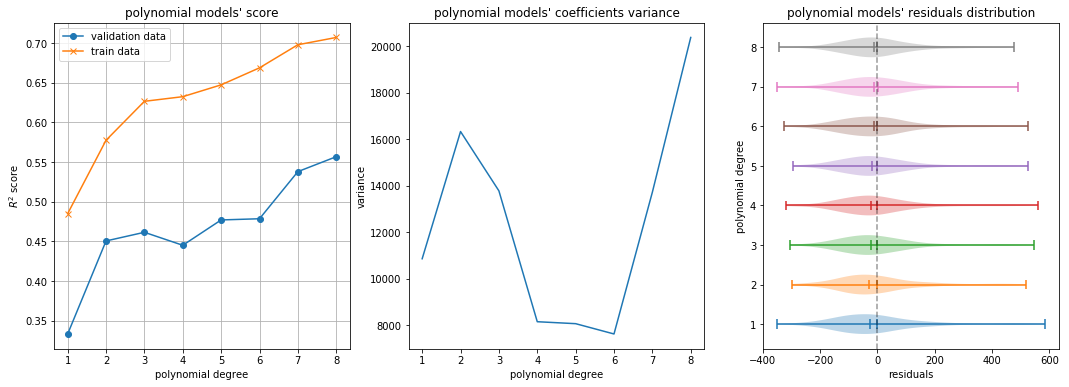

In [51]:
poly_scores_plot(df_poly_scores)

**2.2** Discuss patterns we see in the results from 2.1. Which model would we select, and why?

The R2 score on training data increases as new polynomial features are added to the model (up to 8th power). This trend is expected.

The R2 score on validation data follows a similar trend as on training data; except of a decrease of R2 score when the 4th polynomial order is added. We might need to investigate some multicollinearity effect introduced by those polynomials. By adding a 5th order the increasing R2 trend is resumed.

Most residuals for all models are found below zero for all polynomial orders. 

Normally we would choose the model that provides the best R2 score 0.556 on validation data. Th R2 score indicates the proportion of variance in the counts of bikes riding that can be explained using the predictors. High values of R2 are signs for good model fitness. Therefore the model with 8 degree of polynomials is the one we would select.

However higher model complexity introduces higher variance in the predicted response as shown in the middle plot above. This means that changing the validation data a little bit would come with wider changes in the predicted response. This reduces the significance of regression coefficients and has negative impact on prediction quality. The polynomial degree 6 has the lowest variance ratio with R2 score 0.478 that is still acceptable. We recall having a R2 score 0.445 in project 3 using forward features selection on a quadratic polynomial model. 

If we investigate further by increasing the degree of polynomials, we obtain the plots below. The residual sum of squares becomes higher than the total variance in the original data with polynomial order 17.

At this moment, we would select the model with polynomial terms up to degree 6 because of it seems to offer the most acceptable prediction error, variance and bias. 


In [46]:
df_poly_scores_18, best_poly_score_info_18, best_poly_model_18 = poly_fit(18)

Best R2 score 0.6294230386344067 obtained with polynomial degree 15 but at the cost of a large variance 47000575.32793752


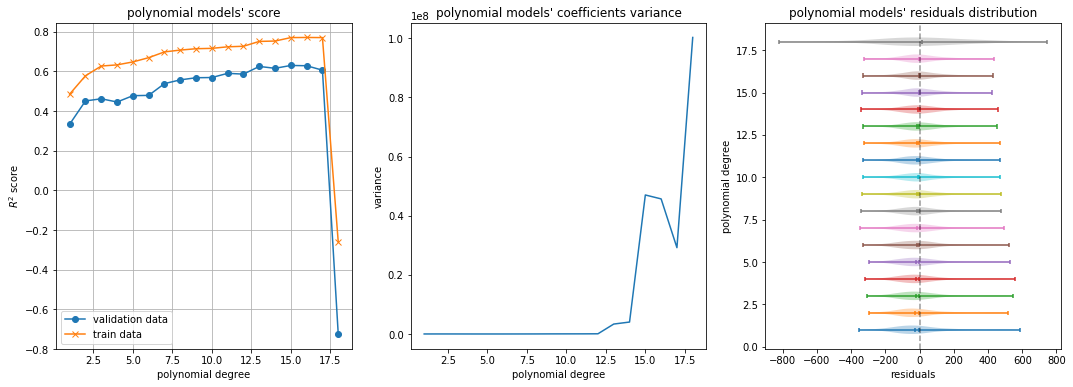

In [47]:
print("Best R2 score " + str(best_poly_score_info_18['score']) + " obtained with polynomial degree " + str(best_poly_score_info_18['degree']) + " but at the cost of a large variance " + str(np.var(best_poly_model_18.coef_)))
poly_scores_plot(df_poly_scores_18)

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. We do not perform cross validation at this point, simply report performance on the single validation set. 


**Model selection with Ridge regularization**

Previously we created different linear regression models with polynomial features. We found out that they provide a good R2 score on validation data. However we were not sure about the importance of predictors and the quality of our estimates in general. Variable selection can be performed by looking for the best subset of predictors, this means searching among 2^193 models. Stepwise forward selection requires less computing effort (18722 possible models). Stepwise backward selection and mixed of both would have a similar computational impact. The best subset of predictors might still miss key predictors, which are significant for the response.

Here we try regularization using a new loss function that augments the MSE with a penalty on large coefficients (except of the intercept). We start with Ridge shrinkage that imposes a constraint on the sum of squares of estimates by shrinking them towards zero. A shrinkage parameter lambda is used to tune the penalty effect. This reduces the variance of those coefficients, what could provide more quality in our predictions and better interpretation of the importance and role of predictors on the response. 

The below function gets a polynomial degree and a list of lambdas as parameters. It creates a ridge regression for each of the lambdas, using predictors which are augmented with their polynomial features up to the specified degree. The function returns the R2 scores obtained on the validation set.

In [52]:
def ridge_fit(max_degree = 8, lambdas = [0, .01, .05, .1, .5, 1, 5, 10, 50, 100]):
    r2_scores_dict = dict()
    coefs_variance_dict = dict()
    residuals_dict = dict()
    poly_degrees = range(1,max_degree + 1)
    r2_scores_dict['poly_degrees'] = poly_degrees
    coefs_variance_dict['poly_degrees'] = poly_degrees
    residuals_dict['poly_degrees'] = poly_degrees
    best_score_dict = {'degree': 0, 'lambda': 0, 'score': 0}
    best_model = None
    for lamb in lambdas:
        r2_scores_val = [] 
        coefs_variance = []
        residuals = []
        for degree in poly_degrees:
            # build the design matrices
            X_train, y_train, X_val, y_val = get_design_mats(bikes_train, bikes_val, degree)               
            # fit a regularized regression model on training data
            ridge = Ridge(alpha = lamb)
            model = ridge.fit(X_train.values, y_train.values)
            # predict on validation data
            y_val_predict_ols = model.predict(X_val.values) 
            # calculate R2 score   
            r2 = r2_score(y_val.values, y_val_predict_ols)
            r2_scores_val.append(r2)
            # retrieve coefficients
            coefs_variance.append(np.var(model.coef_))
            # calculate residuals
            residuals.append(y_val.values - y_val_predict_ols)
            if (r2 > best_score_dict['score']) & (lamb != 0):
                best_score_dict = {'degree': degree, 'lambda': lamb, 'score': r2, 'predictors': X_train.columns.values}
                best_model = model
        r2_scores_dict[r'$\lambda = ' + str(lamb) + '$'] = r2_scores_val
        coefs_variance_dict[r'$\lambda = ' + str(lamb) + '$'] = coefs_variance
        residuals_dict[r'$\lambda = ' + str(lamb) + '$'] = residuals
    return pd.DataFrame(r2_scores_dict), pd.DataFrame(coefs_variance_dict), pd.DataFrame(residuals_dict), best_score_dict, best_model

In [49]:
df_ridge_scores, df_ridge_coefs_variance, df_ridge_residuals, best_ridge_score_info, best_ridge_model = ridge_fit()

**Report Ridge R2 scores**

The following table shows the R2 scores obtained when predicting bikes riding with polynomial Ridge regression model on the validation dataset. The models were trained using the training dataset and candidate $\lambda$s.

The R2 scores are displayed for each value of lambda, the Ridge tuning parameter. We added a lambda=0 for comparison purpose which gives the same results as those obtained with ordinary linear regression (without Ridge).

In [50]:
df_ridge_scores

,poly_degrees,$\lambda = 0$,$\lambda = 0.01$,$\lambda = 0.05$,$\lambda = 0.1$,$\lambda = 0.5$,$\lambda = 1$,$\lambda = 5$,$\lambda = 10$,$\lambda = 50$,$\lambda = 100$
0,1,0.327582,0.334079,0.336303,0.338252,0.344601,0.347245,0.350852,0.350720,0.345421,0.340400
1,2,0.446213,0.451156,0.452777,0.454184,0.458863,0.460860,0.462742,0.461501,0.453643,0.448234
2,3,0.461159,0.462133,0.464616,0.466878,0.474055,0.477064,0.482930,0.484346,0.477066,0.464374
3,4,0.445153,0.445810,0.448139,0.450257,0.457269,0.460419,0.467707,0.470200,0.466792,0.458405
4,5,0.477031,0.477541,0.479419,0.481121,0.486543,0.488813,0.493436,0.494610,0.491686,0.487166
5,6,0.478533,0.479001,0.480442,0.481841,0.487837,0.491471,0.499539,0.501450,0.500695,0.496005
6,7,0.537902,0.538235,0.538780,0.539033,0.537512,0.534090,0.518093,0.511204,0.498667,0.492277
7,8,0.556620,0.556880,0.556861,0.556306,0.548498,0.539885,0.514831,0.508011,0.500281,0.497137


The following function plots the $R^2$ score on validation data, obtained using a Ridge model for each polynomial degree and lambda combination, as well as the corresponding variance of models coefficients after Ridge schrinkage.

In [51]:
def ridge_scores_plot(df_scores, df_coefs_variance):
    lambdas = df_scores.columns.difference(['poly_degrees', '$\lambda = 0$']).values
    fig, ax = plt.subplots(1,2, figsize=(15,6)) 
    for lamb in lambdas:
        ax[0].plot(df_scores.poly_degrees, df_scores[lamb], ls='-', marker='o', markersize=3, label = lamb)
    ax[0].set_ylabel('$R^2$ score')
    ax[0].set_xlabel('polynomial degree');
    ax[0].set_title('Ridge polynomial models\' scores on validation data')
    ax[0].legend()
    ax[0].grid()
    for lamb in lambdas:
        ax[1].plot(df_coefs_variance.poly_degrees, df_coefs_variance[lamb], ls='-', marker='o', markersize=3, label = lamb)
    ax[1].set_ylabel('variance')
    ax[1].set_xlabel('polynomial degree');
    ax[1].set_title('polynomial models\' coefficients variance')
    ax[1].legend()
    ax[1].grid()
    

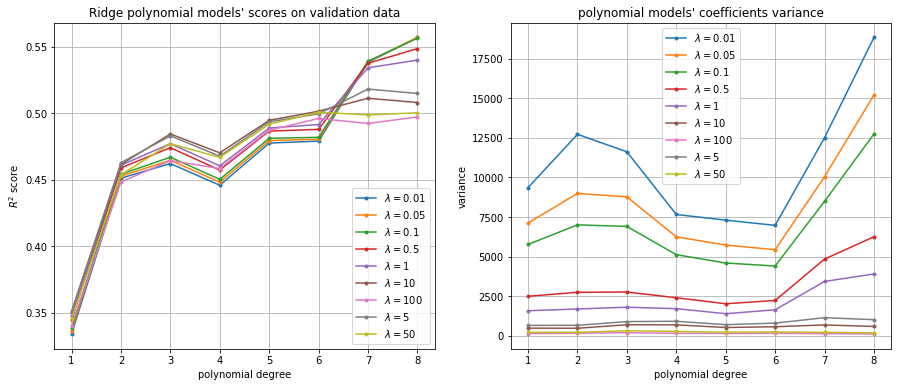

In [52]:
ridge_scores_plot(df_ridge_scores, df_ridge_coefs_variance)

When higher values of $\lambda$ are used, this penalizes high model complexity, causing models with higher polynomial terms to produce a weak R2 score. 

**2.4** Find the best-scoring degree and regularization combination.

In [53]:
print("The best-scoring degree appears to be " + str(best_ridge_score_info['degree']) + " with Ridge tuning parameter " + str(best_ridge_score_info['lambda']) + ". The corresponding regression model provides predictions with R2 score = " + str(best_ridge_score_info['score']) + " at the cost of a high variance of coefficients estimates " + str(np.var(best_ridge_model.coef_)))

The best-scoring degree appears to be 8 with Ridge tuning parameter 0.01. The corresponding regression model provides predictions with R2 score = 0.5568797750209155 at the cost of a high variance of coefficients estimates 18831.150134697655


The variance of coefficients obtained with each degree and lambda combination is given in the table below.

In [54]:
df_ridge_coefs_variance

,poly_degrees,$\lambda = 0$,$\lambda = 0.01$,$\lambda = 0.05$,$\lambda = 0.1$,$\lambda = 0.5$,$\lambda = 1$,$\lambda = 5$,$\lambda = 10$,$\lambda = 50$,$\lambda = 100$
0,1,5.222566e+30,9363.134729,7122.321011,5772.116055,2503.624150,1589.076581,664.420445,490.106225,223.470299,149.419614
1,2,3.652825e+30,12718.887049,8994.156287,7008.703487,2752.361189,1699.541380,669.285740,482.849758,227.107165,163.457885
2,3,7.280216e+28,11618.054508,8769.794417,6908.175510,2771.296449,1811.546327,903.990796,705.026394,325.598688,206.166343
3,4,9.350728e+25,7661.355726,6252.269933,5125.374055,2407.848583,1719.682692,924.209603,697.429542,282.549506,167.378675
4,5,4.481185e+25,7304.584351,5733.383863,4599.811538,2029.424269,1402.063655,709.994021,530.450043,233.330485,153.310133
5,6,7.707326e+23,6975.605831,5440.594851,4412.093598,2237.038878,1649.032736,807.935927,579.042948,250.201631,163.548431
6,7,2.296147e+22,12506.720923,10042.072200,8493.599176,4847.689072,3437.079191,1149.306835,693.392328,225.271901,137.307618
7,8,7.360081e+21,18831.150135,15203.833136,12737.220785,6257.953598,3908.009121,1024.328113,596.845952,195.441777,122.861194


**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**Read test dataset**

In [55]:
bikes_test = pd.read_csv('data/bikes_test.csv', index_col='Unnamed: 0')

bikes_test.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
7955,2011-12-03,3,0,0,0,0.24,0.2424,0.70,0.1343,4,...,0,0,0,0,0,1,0,0,0,12
113,2011-01-05,22,0,0,1,0.18,0.1970,0.55,0.1343,1,...,0,0,1,0,0,0,0,0,0,1
701,2011-02-01,14,0,0,1,0.22,0.2576,0.80,0.0896,5,...,0,1,0,0,0,0,1,0,0,2
12221,2012-05-29,10,1,0,1,0.74,0.6970,0.70,0.2985,67,...,0,1,0,0,0,0,0,0,0,5
7255,2011-11-03,22,0,0,1,0.40,0.4091,0.82,0.0000,21,...,0,0,0,1,0,0,0,0,0,11


**Create design matrices for test data**

We will perform similar data cleaning and preparation on the test dataset as we did for the training and validation dataset. 
We use the same function get_design_mats for this purposes. 

In [56]:
X_train_best, y_train_best, X_test_best, y_test_best = get_design_mats(bikes_train, bikes_test, degree = best_ridge_score_info['degree'])

Explore the test dataset

In [57]:
X_train_best.columns.values

array(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2', 'temp^3',
       'temp^4', 'temp^5', 'temp^6', 'temp^7', 'temp^8', 'atemp^2',
       'atemp^3', 'atemp^4', 'atemp^5', 'atemp^6', 'atemp^7', 'atemp^8',
       'hum^2', 'hum^3', 'hum^4', 'hum^5', 'hum^6', 'hum^7', 'hum^8',
       'windspeed^2', 'windspeed^3', 'windspeed^4', 'windspeed^5',
       'windspeed^6', 'windspeed^7', 'windspeed^8', 'hour^2', 'hour^3',
       'hour^4', 'hour^5', 'hour^6', 'hour^7', 'hour^8', 'temp*Feb',
       'temp*Mar', 'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul',
       'temp*Aug', 'temp*Sept', 'temp*Oct', 'temp*Nov', 'temp*Dec',
       'temp*Mon', 'temp*Tue', 'temp*Wed', 'temp*Thu', 'temp*Fri',
       'temp*Sat', 'atemp*Feb', 'atemp*Mar', 'atemp*Apr', 'atemp*May',
       'atemp*Jun', '

**Predict and get R2 score on test data**

The previous investigations identified the best tuning parameter for the Ridge regularization, combined with the best polynomial order. This model is now fit and used on test data below.

In [58]:
ridge = Ridge(alpha = best_ridge_score_info['lambda'])
model = ridge.fit(X_train_best.values, y_train_best.values)

In [59]:
y_test_predict_ridge = model.predict(X_test_best.values)
r2_score_ridge_test = r2_score(y_test_best.values, y_test_predict_ridge)
print("Test score " + str(r2_score_ridge_test))
print("Validation score " + str(best_ridge_score_info['score']))

Test score 0.5668964072043828
Validation score 0.5568797750209155


**2.6** Why do we think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

It is surpising that the Ridge regression with high variance is performing so well on our test data. The model's test score is a bit higher than its validation score. A reason could be that the distribution of test samples is quite similar to those of the validation set. We observed that after scaling the test data using the mean and std learned from the training data, the std of the test data is close to 1 and their mean is almost zero.

It might be interesting to verify why we are doing better on the test set than on the train set. A reason could be that the validation set inculded outliers.

We will perform cross-validation for reducing variability biais, as well as a Lasso regression in order to force some variables to zero and better understand the effect of each variable on the response.

## Part 3: Comparing Ridge, Lasso, and OLS

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, we will need to increase `max_iter` to 100,000 for the optimization to converge.

**Build a training and validation dataset with polynomial degree 1**

We use the get_design_mats function to create a design matrix.

In [60]:
X_train_1, y_train_1, X_val_1, y_val_1 = get_design_mats(bikes_train, bikes_val, degree = 1)
X_train_1, y_train_1, X_test_1, y_test_1 = get_design_mats(bikes_train, bikes_test, degree = 1)

**Fit an OLS model**

We fit a linear regression model on the training data without polynomial features of higher order.

In [61]:
ols_model = LinearRegression().fit(X_train_1.values, y_train_1.values)
y_val_predicted_ols = ols_model.predict(X_val_1.values)
r2_score_val_ols = r2_score(y_val_1.values, y_val_predicted_ols)
y_test_predicted_ols = ols_model.predict(X_test_1.values)
r2_score_test_ols = r2_score(y_test_1.values, y_test_predicted_ols)

**Fit a Ridge model**

In the previous part we performed regularization on a polynomial multiple linear regression model using Ridge cost function  by choosing the tuning parameter and polynomial degree that provided the best $R^2$ score on validation dataset. 

It could however happen by chance that the validation data set was clustered around the regression line of our chosen model. In this case although we got a good validation score, we could experience a much worse score on production. 

By using cross-validation we can select the best tuning parameter with the lowest cross-validation error. Instead of just using one single validation set, we split our data in chunks (folds) on approximately equal size. For each value of the tuning parameter, we use one fold as validation set, and the remaining folds as training set. We average the errors and at the end we chose the $\lambda$ value that provides the lowest mean error. 

For this purpose let's use the built-in, automated cross validation feature of sklearn for Ridge regression. Since our data has a time predictor, we shuffle the data explicitely before searching for the optimal $\lambda$ via cross-validation.

We use a fold size of 20, as recommended by law of thumb in litterature.

In [62]:
from sklearn.model_selection import KFold
alphas_list = (.1,.5,1,5,10,50,100)
splitter = KFold(n_splits = int(X_train_1.shape[0]/20), random_state=42, shuffle=True)

ridge_cv_model = RidgeCV(alphas=alphas_list, cv=splitter, normalize=False)
ridge_cv_model.fit(X_train_1.values, y_train_1.values)

RidgeCV(alphas=(0.1, 0.5, 1, 5, 10, 50, 100),
    cv=KFold(n_splits=50, random_state=42, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [63]:
print("The Ridge tuning parameter for obtained via cross-validation is " + str(ridge_cv_model.alpha_))

The Ridge tuning parameter for obtained via cross-validation is 50


Now let's fit a multilinear regression model with Ridge regularization on the whole training training set.

In [64]:
ridge_model = Ridge(alpha = ridge_cv_model.alpha_)
ridge_model.fit(X_train_1.values, y_train_1.values)
y_val_predicted_ridge = ridge_model.predict(X_val_1.values)
r2_score_val_ridge = r2_score(y_val_1.values, y_val_predicted_ridge)
y_test_predicted_ridge = ridge_model.predict(X_test_1.values)
r2_score_test_ridge = r2_score(y_test_1.values, y_test_predicted_ridge)

**Fit a Lasso model**

Whereas a Ridge regularization adds a penalty term as sum of sqares of coefficients magnitude, Lasso uses the sum of their absolute values, nulling those with no effect on the response. 

We use cross-validation in order to find the best tuning parameter.

In [65]:
lasso_cv_model = LassoCV(alphas=alphas_list, cv=splitter, max_iter = 100000)
lasso_cv_model.fit(X_train_1.values, y_train_1.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=(0.1, 0.5, 1, 5, 10, 50, 100), copy_X=True,
    cv=KFold(n_splits=50, random_state=42, shuffle=True), eps=0.001,
    fit_intercept=True, max_iter=100000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [66]:
print("The Lasso tuning parameter for obtained via cross-validation is " + str(lasso_cv_model.alpha_))

The Lasso tuning parameter for obtained via cross-validation is 0.5


Now let's fit a multilinear regression model with Lasso regularization on the whole training training set.

In [67]:
lasso_model = Lasso(alpha = lasso_cv_model.alpha_)
lasso_model.fit(X_train_1.values, y_train_1.values)
y_val_predicted_lasso = lasso_model.predict(X_val_1.values)
r2_score_val_lasso = r2_score(y_val_1.values, y_val_predicted_lasso)
y_test_predicted_lasso = lasso_model.predict(X_test_1.values)
r2_score_test_lasso = r2_score(y_test_1.values, y_test_predicted_lasso)

The R2 scores of all three approaches are given below.

In [68]:
pd.DataFrame({'model': ['osl', 'ridge', 'lasso'], 
              'R2 score on val': [r2_score_val_ols, r2_score_val_ridge, r2_score_val_lasso],
              'R2 score on test': [r2_score_test_ols, r2_score_test_ridge, r2_score_test_lasso]})

,model,R2 score on val,R2 score on test
0,osl,0.333359,0.349485
1,ridge,0.345421,0.388293
2,lasso,0.343814,0.374765



**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do we see in the magnitude of the coefficients?

**Retrieve model coefficients**

We retrieve predictor coefficients from our OLS model

In [69]:
coefs = pd.DataFrame({'predictors': X_train_1.columns.values, 'ols': ols_model.coef_.ravel()})
coefs.ols = round(coefs.ols.astype('float'), 2)

We retrieve predictor coefficients from our Ridge model

In [70]:
coefs['ridge'] = ridge_model.coef_.ravel()
coefs.ridge = round(coefs.ridge.astype('float'), 2)

We retrieve predictor coefficients from our Lasso model

In [71]:
coefs['lasso'] = lasso_model.coef_.ravel()
coefs.lasso = round(coefs.lasso.astype('float'), 2)

Let's have a look at the coefficients

In [72]:
coefs.head()

,predictors,ols,ridge,lasso
0,hour,52.90,51.09,52.84
1,year,40.15,38.61,38.49
2,holiday,-12.03,-7.13,-0.00
3,temp,162.09,42.81,79.63
4,atemp,-95.86,34.37,1.63


**Coefficients histograms**

Below is a distribution plot of all coefficients for each model.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


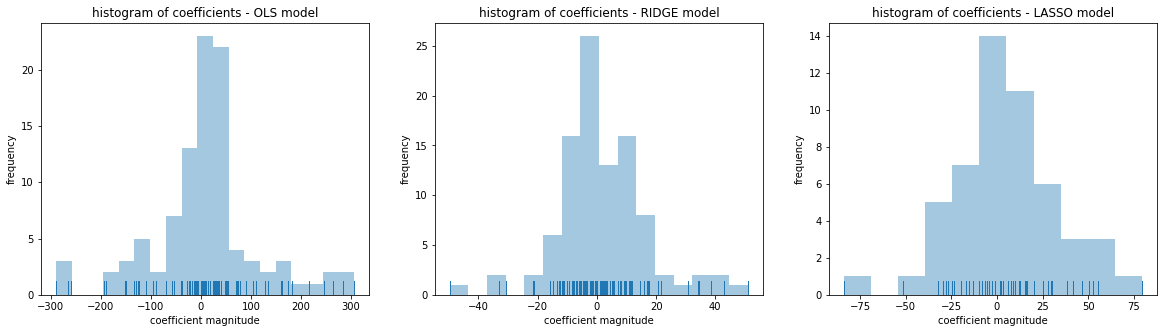

In [73]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(coefs.ols, rug=True, kde=False, norm_hist=False, ax=ax[0])
ax[0].set_title('histogram of coefficients - OLS model')
ax[0].set_xlabel('coefficient magnitude')
ax[0].set_ylabel('frequency')
sns.distplot(coefs.ridge, rug=True, kde=False, norm_hist=False, ax=ax[1])
ax[1].set_title('histogram of coefficients - RIDGE model')
ax[1].set_xlabel('coefficient magnitude')
ax[1].set_ylabel('frequency')
sns.distplot(coefs.lasso[coefs.lasso!=0], rug=True, kde=False, norm_hist=False, ax=ax[2])
ax[2].set_title('histogram of coefficients - LASSO model')
ax[2].set_xlabel('coefficient magnitude')
ax[2].set_ylabel('frequency')
plt.show()

The histograms show smaller magnitude for regularized coefficients. With the OLS model, coefficients are distributed in a wider values range. Ridge and Lasso models have shrinked coefficients with less variance. Lasso caused a lot of coefficients to be zero (we did not show them in the Lasso histogram in order to keep the remaining distribution visible, the list of zero coefficients is given below). 

Outliers coefficient are particularly large in the OLS model. Their magnitude is significantly reduced by Ridge and set to zero by Lasso. Most coefficients are found around zero.

The overall variance of the coefficients for each model is given below.

In [74]:
np.var(coefs.ols), np.var(coefs.ridge), np.var(coefs.lasso)

(10858.067095835073, 223.46875107246984, 422.9162923469388)

The following coefficients were removed by Lasso regression. The corresponding predictors or interaction terms have very little or no effect on the number of bike rides.

In [75]:
coefs[coefs.lasso==0].predictors.values

array(['holiday', 'windspeed', 'Feb', 'May', 'Jul', 'Aug', 'Nov', 'Dec',
       'summer', 'Mon', 'Fri', 'Sat', 'Storm', 'temp*Feb', 'temp*Mar',
       'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul', 'temp*Aug',
       'temp*Oct', 'temp*Nov', 'temp*Fri', 'temp*Sat', 'atemp*Apr',
       'atemp*Jun', 'atemp*Aug', 'atemp*Sept', 'atemp*Oct', 'atemp*Nov',
       'atemp*Dec', 'atemp*Mon', 'atemp*Tue', 'atemp*Wed', 'atemp*Thu',
       'hum*Mar', 'hum*Jun', 'hum*Jul', 'hum*Dec', 'hum*Fri',
       'windspeed*Feb', 'windspeed*Apr', 'windspeed*Dec', 'windspeed*Tue',
       'windspeed*Wed', 'windspeed*Fri'], dtype=object)

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

We first sort the coefficients by overall magnitude.

In [76]:
coefs['all'] = abs(coefs.ols) + abs(coefs.ridge) + abs(coefs.lasso)
coefs = coefs.sort_values(by = ['all'])

The stacked barplot below shows the magnitude of the coefficients associated with the predictors. The predictors with the cummulative largest coefficient magnitude are displayed at the beginning of the plot. The bar shows the magnitude obtained with each of the three models (OLS - blue, Ridge - orange, Lasso - green). 

Bars oriented to the left identify those predictors which have a negative effect on the predicted count of ridership. The remaining ones have a positive effect. A step increase of the later would imply a step increase in the count by the magnitude of the coefficient.

Lasso provides the best interpretability. For example humidity has a considerable impact on ridership during certain months (Sept). High temperature brings definetely more ridership. It is strange that Storm has no effect on the ridership. This is probably because of the lack of data during stormy weather.


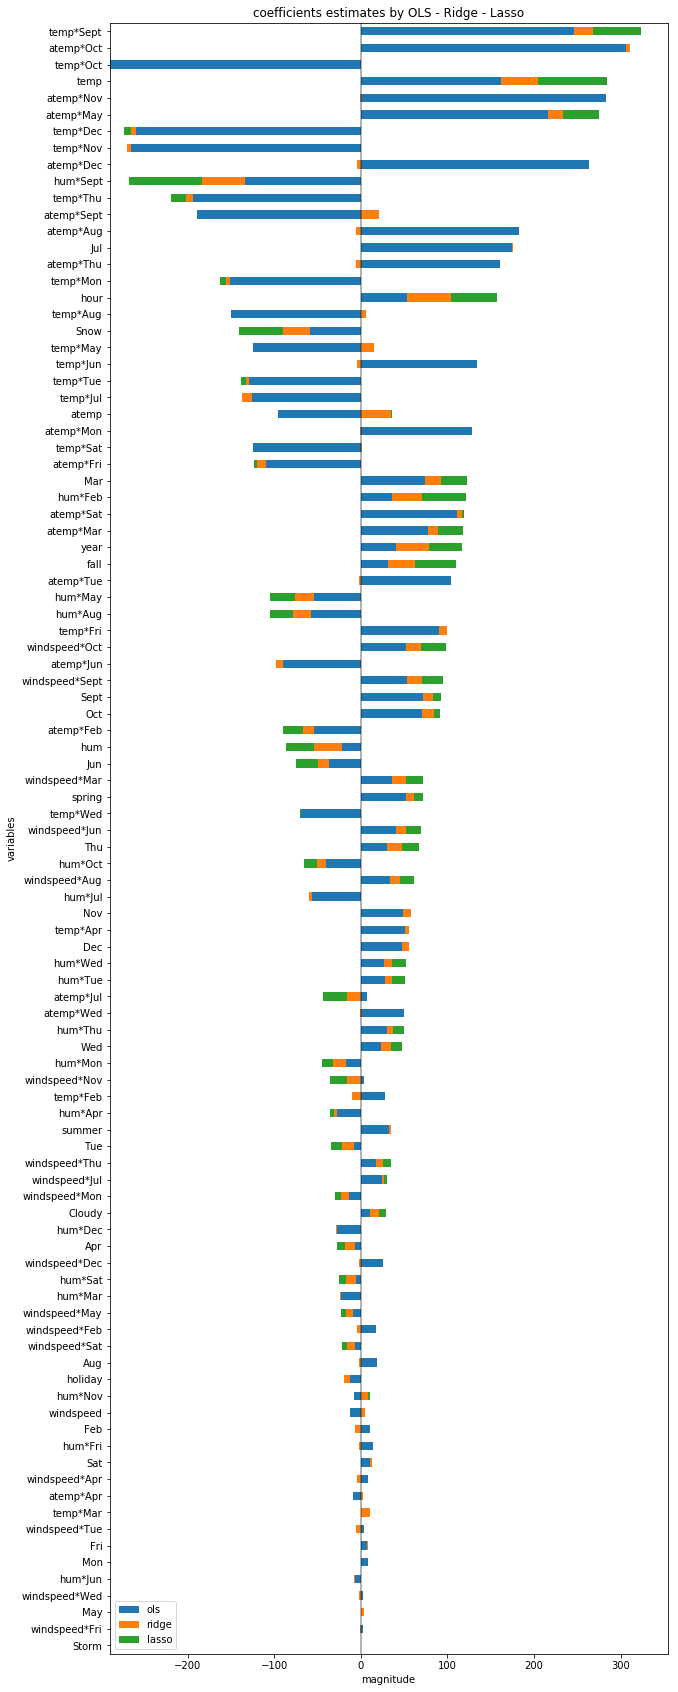

In [77]:
coefs.plot.barh(x='predictors', y=['ols', 'ridge', 'lasso'], stacked=True, legend=True, figsize=(10, 30))
plt.axvline(x=0, color='black', alpha=0.4)
plt.xlabel('magnitude')
plt.ylabel('variables')
plt.title('coefficients estimates by OLS - Ridge - Lasso')
plt.show()

**3.4** What trends do we see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

When the coefficient is large, the sign of coefficients appears to be the same regardless the approach used. The coefficients which were set to zero by Lasso tend to be handled differently by Ridge and OLS when it comes to their sign. 

OLS handles temp as a positive predictor of ridership, and atemp as a negative predictore of ridership. This is strange because both predictors are positively correlated. We would expect temp and atemp to behave in the same direction. This is not the case for Lasso and Ridge approaches, where both temp and atemp predict an increase in ridership.

Ridge assumes that both temp and atemp would have approximately the same impact on the response. Lasso however seems to have detected the collinearity between both and tried to shrink atemp towards zero.

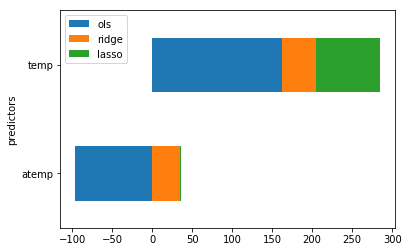

In [78]:
coefs[(coefs.predictors=='temp')|(coefs.predictors=='atemp')].plot.barh(x='predictors', y=['ols', 'ridge', 'lasso'], stacked=True, legend=True, figsize=(6, 4))

## Part 4: Reflection

**4.1** Reflect back on the `get_design_mats` function we built. Writing this function useful in the analysis? What issues might we have encountered if we copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

The get_design_mats function was useful for better code visibility, debugging, it promoted less lines of code, allowing to reuse the same code logic through the questions. If the data structure is the same throughout the project, then using such a function is wise for exploring various polynomial and regularized models. An improvement of get_design_mats could be adding a flag for enabling/disabling the creation of interaction terms, and also providing the list of predictors that could interact as a parameter to the function. get_design_mats could also handle exceptions.

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

Adding polynomials in OLS improves the validation score while increasing prediction variance and risk of overfitting; Ridge/Lasso reduces the variance. Polynomial terms bring multicolinearity issues with them, what negatively affects interpretability; by shrinking the coefficients of less important predictors, Ridge/Lasso helps avoiding that issue. Forward selection identifies the subset of predictors which give the less error, but this approach can miss important predictors. Lasso can help in the special case of high dimensionality where there are more predictors than observations. The down side is, Ridge/Lasso comes at the cost of computation power especcially when the data set is very big.  

**4.3** This project posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., the lasso and ridge models from part 3, how would we react if the models predicted well, but the coefficient values didn't make sense once interpreted?

Although prediction was more important than interpretability in this context, having for example two strange coefficients for temp and atemp, or storm should also be considered closely, as they could affect prediction on another test dataset. Inference should be ideally investigated even if the main goal is prediction. 


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In the view, did we accomplish this goal? If yes, which model would we put into production and why? If not, which model came closest, what other analyses might we conduct, and how likely do we think they are to work

For any given month, day of week, weather forecast and hour of the day, our models are able to predict the number of rides that will be made by both registered and casual users with an acceptable R2 score (see summary table below). However without a proper analysis of coefficients variance, bias, residuals and coefficients p-values/CI, we think that the prediction goal was not fully achieved. 

We suggest a model obtained with interaction terms, polynomial model with degree 6 regularized with Lasso using a tuning parameter obtained via cross-validation. This model would predict with R2 score around 0.478, would bring low coefficients variance, and would consider only significant predictors.  

In [79]:
pd.DataFrame({"Model": ['original', 'polynomial degree 2', 'polynomial degree 2 with forward selection', 'polynomial degree 6 with int. terms', 'multilinear polynomia degree 8 with inter. terms', 'polynomial degree 8 with Ridge lamba 0.1', 'polynomial degree 1 with inter. terms', 'polynomial degree 1 with inter. terms and Ridge', 'polynomial degree 1 with inter. terms and Lasso'], "Test R2": [0.406, 0.496, 0.445, 0.478, 0.556, 0.556, 0.349, 0.388, 0.383]})

,Model,Test R2
0,original,0.406
1,polynomial degree 2,0.496
2,polynomial degree 2 with forward selection,0.445
3,polynomial degree 6 with int. terms,0.478
4,multilinear polynomia degree 8 with inter. terms,0.556
5,polynomial degree 8 with Ridge lamba 0.1,0.556
6,polynomial degree 1 with inter. terms,0.349
7,polynomial degree 1 with inter. terms and Ridge,0.388
8,polynomial degree 1 with inter. terms and Lasso,0.383
